# **CAR PRICE PREDICTION NOTEBOOK**

## **Summary**
1. Importing libraries and data
2. Data cleaning and preparation
3. Data transformation function
4. Training: first models
5. Training: hyperparameters tuning
6. Training: learning curves
7. Model finalization
8. Test on unseen data

.

.

## **1. Importing libraries and data**

In [1]:
#Importing libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
import difflib
from scipy.stats import skew
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import f_regression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')

In [2]:
#Importing data
Data = pd.read_csv("CarPrice_Assignment.csv")
Data

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,201,-1,volvo 145e (sw),gas,std,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,9.5,114,5400,23,28,16845.0
201,202,-1,volvo 144ea,gas,turbo,four,sedan,rwd,front,109.1,...,141,mpfi,3.78,3.15,8.7,160,5300,19,25,19045.0
202,203,-1,volvo 244dl,gas,std,four,sedan,rwd,front,109.1,...,173,mpfi,3.58,2.87,8.8,134,5500,18,23,21485.0
203,204,-1,volvo 246,diesel,turbo,four,sedan,rwd,front,109.1,...,145,idi,3.01,3.40,23.0,106,4800,26,27,22470.0


In [3]:
#Data information
Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   car_ID            205 non-null    int64  
 1   symboling         205 non-null    int64  
 2   CarName           205 non-null    object 
 3   fueltype          205 non-null    object 
 4   aspiration        205 non-null    object 
 5   doornumber        205 non-null    object 
 6   carbody           205 non-null    object 
 7   drivewheel        205 non-null    object 
 8   enginelocation    205 non-null    object 
 9   wheelbase         205 non-null    float64
 10  carlength         205 non-null    float64
 11  carwidth          205 non-null    float64
 12  carheight         205 non-null    float64
 13  curbweight        205 non-null    int64  
 14  enginetype        205 non-null    object 
 15  cylindernumber    205 non-null    object 
 16  enginesize        205 non-null    int64  
 1

.

There are no missing values in the dataset. There are 10 "*object*" categorical features that must be treated before training:
- CarName, fueltype, aspiration, doornumber
- carbody, drivewheel, enginelocation
- enginetype, cylindernumber, fuelsystem


Let's start creating a Training and a Test set: this latter will be used as *unseen data* at the end of the notebook

In [4]:
#Creation of a Training set and a Test set (0.05% - 10 samples)
X_train, X_test, y_train, y_test = train_test_split(Data.drop(["price"],axis=1), 
                                                    Data.price, 
                                                    test_size = 0.05, 
                                                    random_state = 42, shuffle=True)
X_train

,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,cylindernumber,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg
164,165,1,toyota corona,gas,std,two,hatchback,rwd,front,94.5,...,four,98,2bbl,3.19,3.03,9.0,70,4800,29,34
65,66,0,mazda glc,gas,std,four,sedan,rwd,front,104.9,...,four,140,mpfi,3.76,3.16,8.0,120,5000,19,27
175,176,-1,toyota corona,gas,std,four,hatchback,fwd,front,102.4,...,four,122,mpfi,3.31,3.54,8.7,92,4200,27,32
73,74,0,buick century special,gas,std,four,sedan,rwd,front,120.9,...,eight,308,mpfi,3.80,3.35,8.0,184,4500,14,16
152,153,1,toyota corolla 1200,gas,std,four,hatchback,fwd,front,95.7,...,four,92,2bbl,3.05,3.03,9.0,62,4800,31,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,107,1,nissan clipper,gas,std,two,hatchback,rwd,front,99.2,...,six,181,mpfi,3.43,3.27,9.0,160,5200,19,25
14,15,1,bmw z4,gas,std,four,sedan,rwd,front,103.5,...,six,164,mpfi,3.31,3.19,9.0,121,4250,20,25
92,93,1,nissan latio,gas,std,four,sedan,fwd,front,94.5,...,four,97,2bbl,3.15,3.29,9.4,69,5200,31,37
179,180,3,toyota corona,gas,std,two,hatchback,rwd,front,102.9,...,six,171,mpfi,3.27,3.35,9.3,161,5200,19,24


.

.

## **2. Data cleaning and preparation**

In [5]:
#Remove "car_ID" column (not useful for predicting the car price)
X_train.drop(["car_ID"],axis=1, inplace=True)

#Print unique values of "object" features
for i in X_train.columns :
    if X_train[i].dtype == "object" :
        print(i, ": ", X_train[i].unique())

CarName :  ['toyota corona' 'mazda glc' 'buick century special' 'toyota corolla 1200'
 'chevrolet impala' 'mitsubishi outlander' 'mitsubishi pajero'
 'subaru baja' 'mazda glc custom l' 'nissan dayz' 'nissan clipper'
 'honda civic' 'dodge colt hardtop' 'bmw x5' 'toyota corolla'
 'volvo 144ea' 'nissan note' 'volvo 145e (sw)' 'buick electra 225 custom'
 'plymouth fury iii' 'toyota corolla 1600 (sw)' 'volvo 244dl'
 'mitsubishi g4' 'buick century' 'subaru r2' 'mazda 626'
 'isuzu D-Max V-Cross' 'mitsubishi mirage g4' 'subaru trezia'
 'mazda rx-7 gs' 'peugeot 504' 'toyota corona hardtop' 'nissan latio'
 'honda civic 1300' 'dodge monaco (sw)' 'subaru dl' 'peugeot 604sl'
 'dodge coronet custom (sw)' 'chevrolet monte carlo'
 'toyota corolla liftback' 'nissan gt-r' 'nissan titan' 'audi fox'
 'toyota corona liftback' 'porsche boxter' 'mitsubishi mirage' 'subaru r1'
 'nissan teana' 'toyota mark ii' 'mercury cougar' 'toyota celica gt'
 'honda civic cvcc' 'bmw x1' 'honda accord lx' 'porsche macan'
 '

.

There might be some upper cases and it is convenient to reduce them to lower cases (they will be treated later).

Now, it is possible to convert the values of categorical features from strings to numbers.

Some categorical features (i.e., "cylindernumber", "doornumber") have a rank order that must be kept into account.

Moreover, in the process, some additional information can be added (e.g. a different number of doors/cylinders).

In [6]:
#Reduce "CarName" to lower cases
for i in X_train.columns :
    if X_train[i].dtype == "object" :
        X_train[i] = X_train[i].map(lambda p: p.lower())
        

#Convert strings to numbers (rank order)
X_train["doornumber"].replace(['two','three','four'], [2,3,4], inplace=True)
X_train["cylindernumber"].replace(['one','two','three','four','five','six','seven',
                                   'eight','nine','ten','eleven','twelve'], 
                                  [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)


#Convert strings to numbers (other categorical features)
for i in X_train.columns :
    if (X_train[i].dtype == "object") & (i != "doornumber") & (i != "cylindernumber") & (i != "CarName") :
        exec(f"X_range_{i} = np.sort(X_train[i].unique()); X_train[i].replace(X_range_{i},np.arange(1,len(X_range_{i})+1), inplace=True)")

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 164 to 102
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         194 non-null    int64  
 1   CarName           194 non-null    object 
 2   fueltype          194 non-null    int64  
 3   aspiration        194 non-null    int64  
 4   doornumber        194 non-null    int64  
 5   carbody           194 non-null    int64  
 6   drivewheel        194 non-null    int64  
 7   enginelocation    194 non-null    int64  
 8   wheelbase         194 non-null    float64
 9   carlength         194 non-null    float64
 10  carwidth          194 non-null    float64
 11  carheight         194 non-null    float64
 12  curbweight        194 non-null    int64  
 13  enginetype        194 non-null    int64  
 14  cylindernumber    194 non-null    int64  
 15  enginesize        194 non-null    int64  
 16  fuelsystem        194 non-null    int64  


.

For what concerns the feature "*CarName*": the first part is the car brand followed by a subclass. 

For training, let's keep only the car brand.

In [7]:
#Transform "CarName" (unique values)
X_train["CarName"] = X_train["CarName"].str.split(" ", expand=True)[0]
np.sort(X_train["CarName"].unique())

array(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge',
       'honda', 'isuzu', 'jaguar', 'maxda', 'mazda', 'mercury',
       'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porcshce',
       'porsche', 'renault', 'saab', 'subaru', 'toyota', 'toyouta',
       'volkswagen', 'volvo', 'vw'], dtype=object)

.

There are two mispelled words that must be corrected before moving on:
- toyouta     for    *toyota*
- porcshce    for    *porsche*

In [8]:
#Correction of mispelled words
Index1 = np.where(X_train["CarName"]=="toyouta")[0]
Index2 = np.where(X_train["CarName"]=="porcshce")[0]
X_train["CarName"].iloc[Index1] = "toyota"
X_train["CarName"].iloc[Index2] = "porsche"
X_train["CarName"] = X_train["CarName"].str.split(" ", expand=True)[0]


#Convert strings to numbers
X_train["CarName"].replace(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge',
                            'honda', 'isuzu', 'jaguar', 'maxda', 'mazda', 'mercury',
                            'mitsubishi', 'nissan', 'peugeot', 'plymouth', 'porsche',
                            'renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo', 'vw'],
                            [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], 
                            inplace=True)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 164 to 102
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   symboling         194 non-null    int64  
 1   CarName           194 non-null    int64  
 2   fueltype          194 non-null    int64  
 3   aspiration        194 non-null    int64  
 4   doornumber        194 non-null    int64  
 5   carbody           194 non-null    int64  
 6   drivewheel        194 non-null    int64  
 7   enginelocation    194 non-null    int64  
 8   wheelbase         194 non-null    float64
 9   carlength         194 non-null    float64
 10  carwidth          194 non-null    float64
 11  carheight         194 non-null    float64
 12  curbweight        194 non-null    int64  
 13  enginetype        194 non-null    int64  
 14  cylindernumber    194 non-null    int64  
 15  enginesize        194 non-null    int64  
 16  fuelsystem        194 non-null    int64  


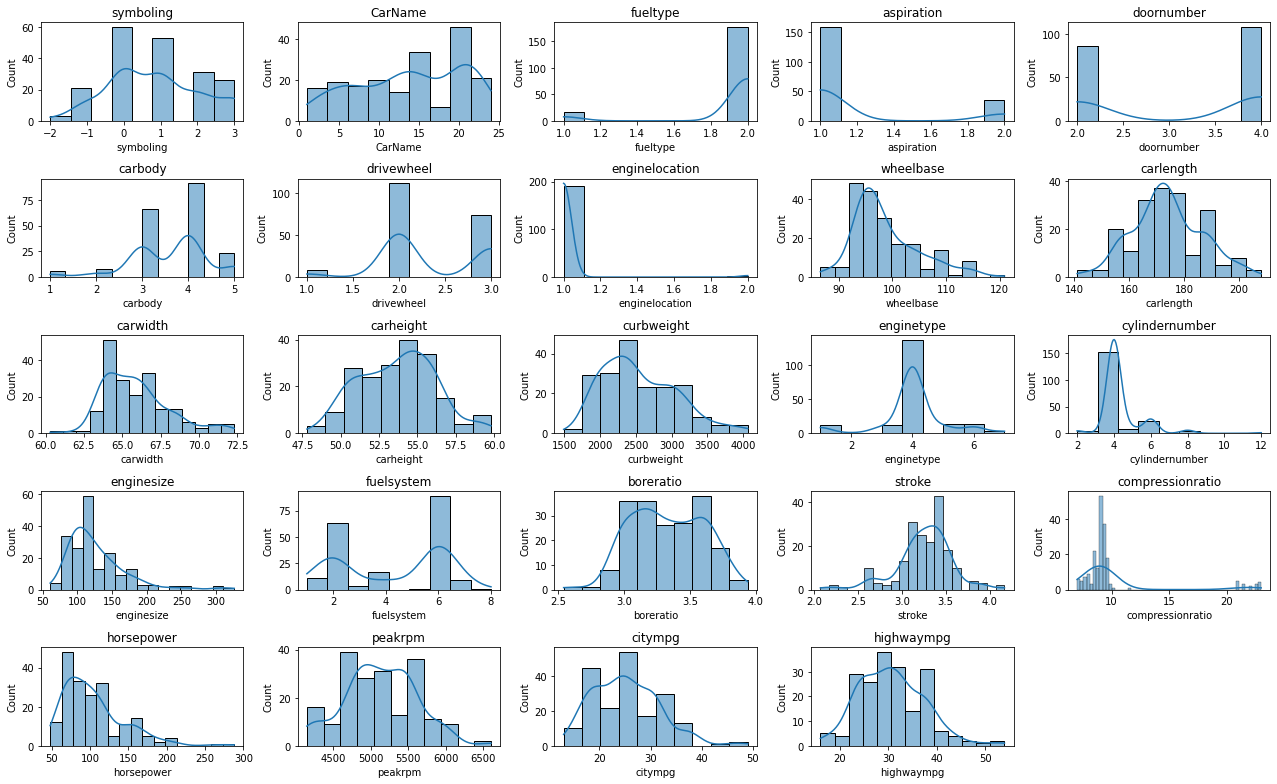

In [9]:
#Data distribution
plt.figure(figsize=(18,11))
k=1
for i in X_train.columns :
    plt.subplot(5,5,k)
    sn.histplot(x=X_train[i],kde=True)
    plt.title(i)
    k=k+1
plt.tight_layout()

.

Front the plots above:
- The majority of car engines work with gas ("*fueltype*")
- The majority of cars have the engine on the front ("*enginelocation*")
- The majority of cars have an engine type "l" ("*enginetype*")

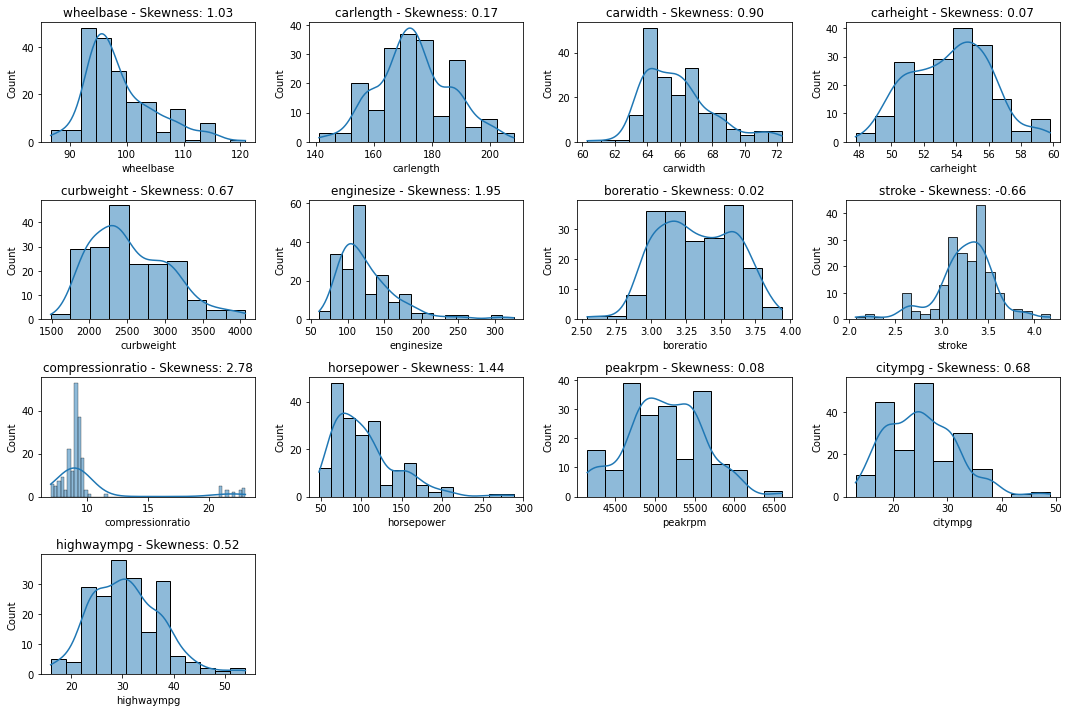

In [10]:
#Data distribution (original numerical features)
plt.figure(figsize=(15,10))
k=1
for i in ["wheelbase","carlength","carwidth","carheight","curbweight","enginesize","boreratio",
          "stroke","compressionratio","horsepower","peakrpm","citympg","highwaympg"] :
    plt.subplot(4,4,k)
    sn.histplot(x=X_train[i],kde=True)
    plt.title("{} - Skewness: {:.2f}".format(i, skew(X_train[i])))
    k=k+1
plt.tight_layout()

.

Those distributions do not span a wide range of values therefore, there is no need to use a log (or any other) transformation.

Let's take a look at the correlation coefficients between features to find possible strong correlations.

In [11]:
#Correlation Matrix (with correlation coefficient larger than 0.8)
High_corr = pd.DataFrame([X_train.columns[np.where((abs(X_train.corr())>=0.8))[0]],
                          X_train.columns[np.where((abs(X_train.corr())>=0.8))[1]]],
                         index=["Val1","Val2"]).T
    
High_corr.drop(np.where(High_corr.Val1 == High_corr.Val2)[0],axis=0, inplace=True)  #Remove diagonal correlations
High_corr

,Val1,Val2
3,fueltype,compressionratio
10,wheelbase,carlength
11,carlength,wheelbase
13,carlength,carwidth
14,carlength,curbweight
15,carwidth,carlength
17,carwidth,curbweight
19,curbweight,carlength
20,curbweight,carwidth
22,curbweight,enginesize


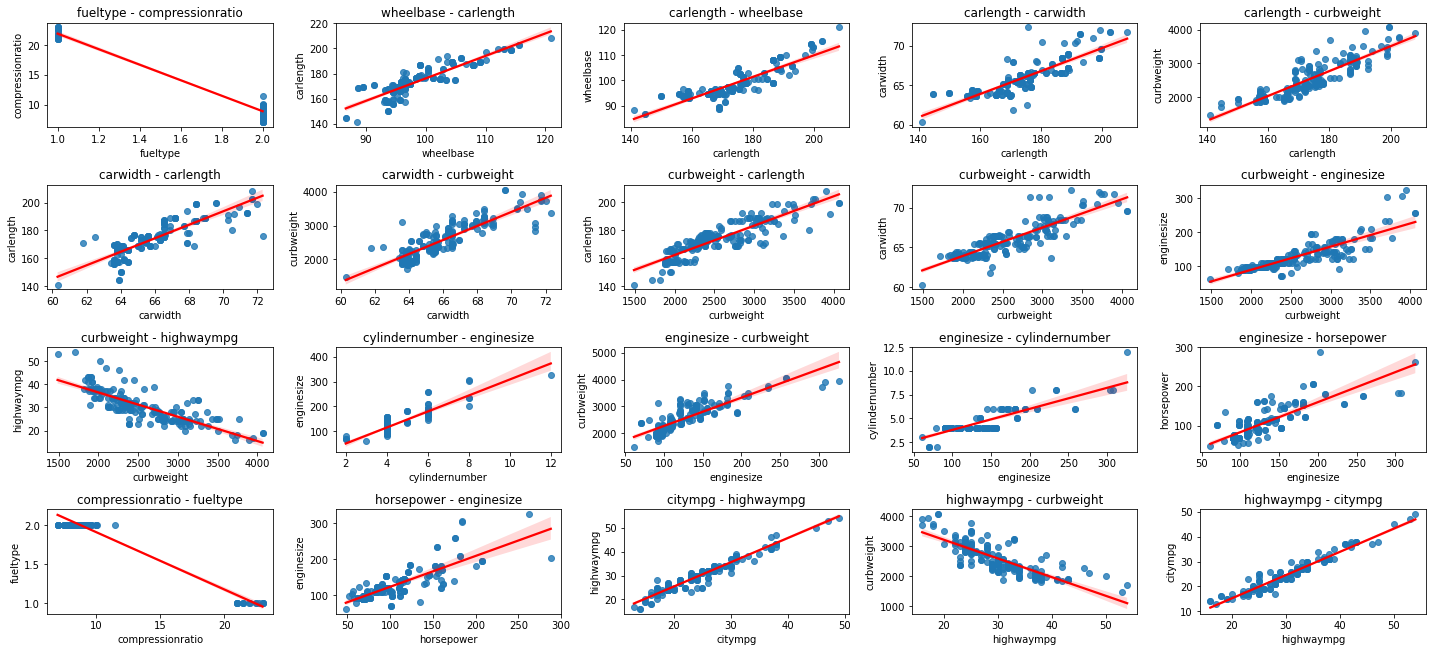

In [12]:
#Plot of the correlated features
plt.figure(figsize=(20,20))
k=1
i=0
while i<len(High_corr) :
    plt.subplot(9,5,k)
    sn.regplot(data = X_train, x = High_corr.Val1.iloc[i], y = High_corr.Val2.iloc[i], line_kws={"color": "red"})
    plt.title("{} - {}".format(High_corr.Val1.iloc[i],High_corr.Val2.iloc[i]))
    i=i+1
    k=k+1
plt.tight_layout()

.

From the plots above:
 - Some features are highly correlated (e.g. *citympg* vs. *highwaympg*) and they may be removed from the dataset
 - Some of them are correlated with what it seems a second degree polynomial (e.g., *curbweight* vs. *enginesize*)

However, there is still a visible scatter in all plots. For now, no feature will be removed from the dataset.

Text(0.5, 1.0, 'Skewness: 1.79')

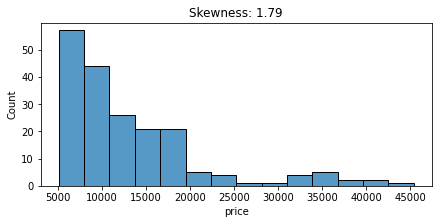

In [13]:
#Target variable
plt.figure(figsize=(7,3))
sn.histplot(x=y_train)
plt.title("Skewness: {:.2f}".format(skew(y_train)))

.

It spans a large range of values therefore, it can be log-transformed.

Text(0.5, 1.0, 'Skewness: 0.66')

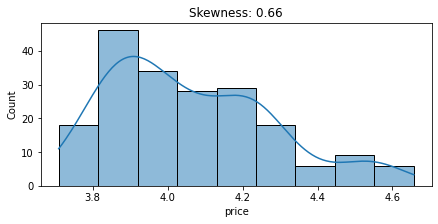

In [14]:
#Log-transformation
y_train = np.log10(y_train)

#Plot
plt.figure(figsize=(7,3))
sn.histplot(x=y_train,kde=True)
plt.title("Skewness: {:.2f}".format(skew(y_train)))

.

Now, let's understand if some features can be removed from the dataset because non-significant for predicting the target variable.

In [15]:
#Feature selection
#Correlation coefficients between features and target variable (from the Correlation Matrix)
Corr_coeff = pd.concat([X_train,pd.Series(np.array(y_train),name="price")],axis=1).corr()["price"]
Corr_coeff[abs(Corr_coeff).sort_values()<=0.05]

symboling           0.035303
fueltype            0.006131
doornumber          0.020612
carbody             0.034391
drivewheel          0.020269
wheelbase           0.038103
carlength           0.010254
carwidth           -0.028949
curbweight         -0.035512
enginetype         -0.028848
fuelsystem         -0.040060
boreratio          -0.035194
stroke              0.027939
compressionratio    0.003492
citympg             0.043158
highwaympg          0.049531
Name: price, dtype: float64

.

The features above are those weakly correlated with the target variable (coefficient<0.05).

Let's compute the p-value.

In [16]:
#P-value
#Select only feature with a p-value larger than 0.05
P_value = pd.DataFrame(f_regression(X_train, y_train)[1],
                       index=X_train.columns,columns=["P_value"]).sort_values(by="P_value",ascending=False)
Pval_005 = P_value.iloc[np.where(P_value>=0.05)[0]]
Pval_005

,P_value
enginetype,0.916498
carbody,0.493423
symboling,0.322524
doornumber,0.282367
stroke,0.237888
peakrpm,0.181710
compressionratio,0.160432


.

Those features are similar to those obtained from the Correlation matrix.

Let's drop these latter (having a p-value larger than 0.05).

In [17]:
#Remove non-significant features (p-value > 0.05)
X_train.drop(Pval_005.index,axis=1,inplace=True)
X_train

,CarName,fueltype,aspiration,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,curbweight,cylindernumber,enginesize,fuelsystem,boreratio,horsepower,citympg,highwaympg
164,21,2,1,3,1,94.5,168.7,64.0,52.6,2204,4,98,2,3.19,70,29,34
65,11,2,1,3,1,104.9,175.0,66.1,54.4,2670,4,140,6,3.76,120,19,27
175,21,2,1,2,1,102.4,175.6,66.5,53.9,2414,4,122,6,3.31,92,27,32
73,4,2,1,3,1,120.9,208.1,71.7,56.7,3900,8,308,6,3.80,184,14,16
152,21,2,1,2,1,95.7,158.7,63.6,54.5,2015,4,92,2,3.05,62,31,38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,14,2,1,3,1,99.2,178.5,67.9,49.7,3139,6,181,6,3.43,160,19,25
14,3,2,1,3,1,103.5,189.0,66.9,55.7,3055,6,164,6,3.31,121,20,25
92,14,2,1,2,1,94.5,165.3,63.8,54.5,1938,4,97,2,3.15,69,31,37
179,21,2,1,3,1,102.9,183.5,67.7,52.0,3016,6,171,6,3.27,161,19,24


In [18]:
#Scaling features (MinMaxScaler)
Set_scaler = MinMaxScaler()
Set_scaler.fit(X_train)
X_train = pd.DataFrame(Set_scaler.transform(X_train), columns = X_train.columns)

.

.

## **3. Data transformation function**

Before moving on with training, a function will be created to transform new data (before the application of the final model) 

adopting all the procedures and transformations shown above. 

The function includes also an additional procedure to find and correct mispelled words

In [19]:
def Data_transformation(X,y) :                      
    #(1A) Remove "car_ID" column
    X.drop(["car_ID"],axis=1, inplace=True)

    #(1B) Reduce "object" features to lower cases
    for i in X.columns :
        if X[i].dtype == "object" :
            X[i] = X[i].map(lambda p: p.lower())
            
    #(2) Categorical features
    X["doornumber"].replace(['two','three','four'], [2,3,4], inplace=True)
    X["cylindernumber"].replace(['one','two','three','four','five','six','seven',
                                 'eight','nine','ten','eleven','twelve'], 
                                [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)
    
    for i in X.columns :
        if (X[i].dtype == "object") & (i != "doornumber") & (i != "cylindernumber") & (i != "CarName") :
            exec(f"X[i].replace(X_range_{i},np.arange(1,len(X_range_{i})+1), inplace=True)")

    #(3) CarName
    X["CarName"] = X["CarName"].str.split(" ", expand=True)[0]
    X["CarName"].replace(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge', 'honda', 'isuzu', 
                        'jaguar', 'maxda', 'mazda', 'mercury','mitsubishi', 'nissan', 'peugeot', 'plymouth', 
                        'porsche','renault', 'saab', 'subaru', 'toyota', 'volkswagen', 'volvo', 'vw'],
                         [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], inplace=True)
    
    #(4) Remove non-significant features (p-value > 0.05)
    X.drop(Pval_005.index,axis=1,inplace=True)

    #(5) Correct Mispelled words for each categorical feature
    Row = []
    Col = []
    for i in range(X.shape[0]) :
        for j in range(X.shape[1]) :
            if isinstance(X.iloc[i,j], str) == True :
                Row.append(i)
                Col.append(j)
            
    if len(Row)>0 :
        for i in range(len(Row)) :
            a = X.columns[Col[i]]
            if a == "CarName" :
                b = difflib.get_close_matches(X.iloc[Row[i],Col[i]], ['alfa-romero', 'audi', 'bmw', 'buick',
                            'chevrolet', 'dodge', 'honda', 'isuzu','jaguar', 'maxda', 'mazda', 'mercury',
                            'mitsubishi', 'nissan', 'peugeot', 'plymouth','porsche','renault', 'saab', 'subaru',
                            'toyota', 'volkswagen', 'volvo', 'vw'])
                X.iloc[Row[i],Col[i]] = b[0]
                X["CarName"].replace(['alfa-romero', 'audi', 'bmw', 'buick', 'chevrolet', 'dodge', 'honda',
                                      'isuzu','jaguar', 'maxda', 'mazda', 'mercury','mitsubishi', 'nissan',
                                      'peugeot', 'plymouth','porsche','renault', 'saab', 'subaru', 'toyota',
                                      'volkswagen', 'volvo', 'vw'],
                                      [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24],
                                      inplace=True)
                
            elif a == "doornumber" :
                b = difflib.get_close_matches(X.iloc[Row[i],Col[i]], ['two','three','four'])
                X.iloc[Row[i],Col[i]] = b[0]
                X["doornumber"].replace(['two','three','four'],[2,3,4], inplace=True)
            
            elif a == "cylindernumber" :
                b = difflib.get_close_matches(X.iloc[Row[i],Col[i]],['one','two','three','four','five','six',
                                                            'seven','eight','nine','ten','eleven','twelve'])
                X.iloc[Row[i],Col[i]] = b[0]
                X["cylindernumber"].replace(['one','two','three','four','five','six','seven','eight',
                                             'nine','ten','eleven','twelve'],
                                             [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)
            
            else :
                exec("Values = X_range_{a}")
                b = difflib.get_close_matches(X.iloc[Row[i],Col[i]], Values)
                X.iloc[Row[i],Col[i]] = b[0]
    
    #(6) Object-to-numeric convertion (if the conversion produces NaN values, they will be replaced with 0)
    for i in X.columns :
        X[i] = pd.to_numeric(X[i], errors='coerce').fillna(int(0))
    
    #(7) Scaling features
    X = pd.DataFrame(Set_scaler.transform(X), columns = X.columns)

    #(8) Target variable (some indexing of the training set)
    y = np.log10(y)
    y = pd.Series(np.array(y),name="price")   
    
    return X,y

.

.

## **4. Training: first models**

First, let's create a Training set (for building models) and a Test set (to evaluate the final model performance).

In [20]:
#Creation of a Training and a Validation set (split: 80-20%)
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_train, y_train, 
                                                            test_size = 0.2, 
                                                            random_state = 42, shuffle=True)

.

Several model will be trained using a repeated random sampling cross-validation method.

Each model performance will be evaluated in terms of RMSE, MAE, and R2.

In [21]:
Iterations = 60
RMSE_lin, RMSE_rid, RMSE_tree, RMSE_ran, RMSE_xgb = 0,0,0,0,0
MAE_lin, MAE_rid, MAE_tree, MAE_ran, MAE_xgb = 0,0,0,0,0
R2_lin, R2_rid, R2_tree, R2_ran, R2_xgb = 0,0,0,0,0
for i in range(Iterations) :
    print(f'\rProcess (%): {100*(i)/(Iterations)}', end='')       #Counter (%)
    
    #Training and Validation set (80-20%)
    X_tr, X_va, y_tr, y_va = train_test_split(X_train_t, y_train_t, test_size = 0.2, random_state = i)
    
    #Linear
    Model_lin = LinearRegression()
    Model_lin2 = Model_lin.fit(X_tr, y_tr)
    RMSE_lin = RMSE_lin + np.sqrt(sum((Model_lin2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_lin = MAE_lin + sum(abs(Model_lin2.predict(X_va) - y_va))/len(y_va)
    R2_lin = R2_lin + r2_score(y_va,Model_lin2.predict(X_va))
    
    #Ridge
    Model_rid = Ridge()
    Model_rid2 = Model_rid.fit(X_tr, y_tr)
    RMSE_rid = RMSE_rid + np.sqrt(sum((Model_rid2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_rid = MAE_rid + sum(abs(Model_rid2.predict(X_va) - y_va))/len(y_va)
    R2_rid = R2_rid + r2_score(y_va,Model_rid2.predict(X_va))
    
    #Decision Tree
    Model_tree = DecisionTreeRegressor(random_state=0)           
    Model_tree2 = Model_tree.fit(X_tr, y_tr)
    RMSE_tree = RMSE_tree + np.sqrt(sum((Model_tree2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_tree = MAE_tree + sum(abs(Model_tree2.predict(X_va) - y_va))/len(y_va)
    R2_tree = R2_tree + r2_score(y_va,Model_tree2.predict(X_va))

    #Random Forest
    Model_ran = RandomForestRegressor(random_state=0)           
    Model_ran2 = Model_ran.fit(X_tr, y_tr)
    RMSE_ran = RMSE_ran + np.sqrt(sum((Model_ran2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_ran = MAE_ran + sum(abs(Model_ran2.predict(X_va) - y_va))/len(y_va)
    R2_ran = R2_ran + r2_score(y_va,Model_ran2.predict(X_va))
    
    #XGBoost
    Model_xgb = xgb.XGBRegressor(seed=0)
    Model_xgb2 = Model_xgb.fit(X_tr, y_tr)
    RMSE_xgb = RMSE_xgb + np.sqrt(sum((Model_xgb2.predict(X_va) - y_va)**2)/len(y_va))
    MAE_xgb = MAE_xgb + sum(abs(Model_xgb2.predict(X_va) - y_va))/len(y_va)
    R2_xgb = R2_xgb + r2_score(y_va,Model_xgb2.predict(X_va))
    

#First results
Data_res = {"RMSE": [RMSE_lin/Iterations, RMSE_rid/Iterations, RMSE_tree/Iterations, 
                     RMSE_ran/Iterations, RMSE_xgb/Iterations],
            "MAE": [MAE_lin/Iterations, MAE_rid/Iterations, MAE_tree/Iterations, 
                    MAE_ran/Iterations, MAE_xgb/Iterations],
            "R2": [R2_lin/Iterations, R2_rid/Iterations, R2_tree/Iterations, 
                   R2_ran/Iterations, R2_xgb/Iterations]}
        
Results = pd.DataFrame(data = Data_res, index=["Linear","Ridge","DecisionTree","RandomForest","XGBoost"])
Results

Process (%): 98.333333333333336

,RMSE,MAE,R2
Linear,0.075466,0.059413,0.878005
Ridge,0.072946,0.057776,0.885484
DecisionTree,0.079866,0.062241,0.860221
RandomForest,0.064215,0.050370,0.910275
XGBoost,0.066277,0.052849,0.905430


.

.

## **5. Training: hyperparameters tuning**

From the table above, the best models are Ridge, RandomForest, and XGBoost (lowest RMSE, MAE, and highest R2).

Let's use them and tune their hyperparameters.

In [22]:
#Hyperameters grid
Params_rid = {"alpha":[0.005,0.01,0.05,0.1,0.5,1,5,10,50,100]}
Params_xgb = {"n_estimators":[100,200], "max_depth":[2,3,4], "learning_rate":[0.1,0.3], "min_split_loss":[0,0.02,0.05],"subsample":[0.5,0.8], "seed":[0]}
Params_ran = {"n_estimators":[100,200], "max_depth":[2,3,4], "min_samples_split":[2,3,5],"min_samples_leaf":[1,3,5],"random_state":[0]}

#Grid search with a 5-fold cross-validation method (the score will be the MAE)
CV = KFold(n_splits=5, random_state = 0, shuffle=True)
Grid_rid = GridSearchCV(Model_rid, cv = CV, param_grid = Params_rid, scoring = "neg_mean_absolute_error", n_jobs = -1, return_train_score=True)
Grid_rid2 = Grid_rid.fit(X_train_t, y_train_t)
print("Ridge model: done!")
Grid_xgb = GridSearchCV(Model_xgb, cv = CV, param_grid = Params_xgb, scoring = "neg_mean_absolute_error", n_jobs = -1, return_train_score=True)
Grid_xgb2 = Grid_xgb.fit(X_train_t, y_train_t)
print("XGboost model: done!")
Grid_ran = GridSearchCV(Model_ran, cv = CV, param_grid = Params_ran, scoring = "neg_mean_absolute_error", n_jobs = -1, return_train_score=True)
Grid_ran2 = Grid_ran.fit(X_train_t, y_train_t)
print("RandomForest model: done!")

print("\n\nThe best Ridge Regression model is: ", Grid_rid2.best_params_)
print("The best XGBoost Regression model is: ",Grid_xgb2.best_params_)
print("The best Random Forest Regression model is: ",Grid_ran2.best_params_)
print("\nThe best Ridge Regression MAE is: ", -Grid_rid2.best_score_)
print("The best XGBoost Regression MAE is: ",-Grid_xgb2.best_score_)
print("The best Random Forest Regression MAE is: ",-Grid_ran2.best_score_)

Ridge model: done!
XGboost model: done!
RandomForest model: done!


The best Ridge Regression model is:  {'alpha': 0.5}
The best XGBoost Regression model is:  {'learning_rate': 0.1, 'max_depth': 4, 'min_split_loss': 0, 'n_estimators': 100, 'seed': 0, 'subsample': 0.8}
The best Random Forest Regression model is:  {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200, 'random_state': 0}

The best Ridge Regression MAE is:  0.05642894975434191
The best XGBoost Regression MAE is:  0.044314067923707276
The best Random Forest Regression MAE is:  0.052069488199465684


.

The best one is the XGBoost model.

However, there might be the possibility that those models (or some of them) are overfitting the data

Let's take a look at the training and validation accuracy plot.

A shaded blue region will drawn and considered as a sort of "confidence interval against overfitting":

Points inside the region are related to models that do not overfit the data

Points ouside the region are related to models that do overfit the data.

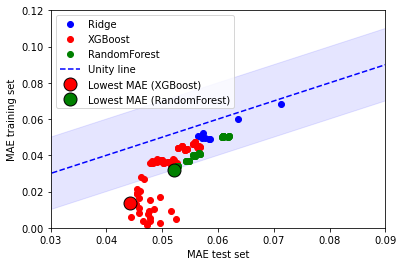

In [23]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(-Grid_rid2.cv_results_["mean_test_score"]),pd.Series(-Grid_rid2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(-Grid_xgb2.cv_results_["mean_test_score"]),pd.Series(-Grid_xgb2.cv_results_["mean_train_score"])],axis=1)
C = pd.concat([pd.Series(-Grid_ran2.cv_results_["mean_test_score"]),pd.Series(-Grid_ran2.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
C.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
C.sort_values("Test")
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot(C.Test,C.Train,'og')
plt.xlim([0.03,0.09])
plt.ylim([-0.0,0.12])
plt.plot([0.0,0.1],[0.0,0.1],'--b')
plt.fill_between([0.0,0.1],[0.02,0.12],[-0.02,0.08],color='blue',alpha=0.1,label="_nolegend_")
plt.plot(B.Test[np.argmin(B.Test)],B.Train[np.argmin(B.Test)],'ro',markersize=13,mec="black")
plt.plot(C.Test[np.argmin(C.Test)],C.Train[np.argmin(C.Test)],'go',markersize=13,mec="black")
plt.xlabel("MAE test set")
plt.ylabel("MAE training set")
plt.legend(["Ridge","XGBoost","RandomForest","Unity line","Lowest MAE (XGBoost)","Lowest MAE (RandomForest)"], loc="upper left")

.

The best XGBoost model is overfitting the data (outside the blue region).

The RandomForest model is at the edge of the blue region while the Ridge model is not overfitting the data (despite its MAE is larger).

Let's use the Random Forest model and tune further its hyperparameters.

In [24]:
#Hyperparameter grid
Params_ran = {"n_estimators":[200], "max_depth":[2,4,5], "min_samples_split":[2,3],"min_samples_leaf":[1,2],"random_state":[0],
              "max_features":["sqrt",10], "min_impurity_decrease":[0,0.1]}

CV = KFold(n_splits=5, random_state = 0, shuffle=True)
Grid_ran22 = GridSearchCV(Model_ran, cv = CV, param_grid = Params_ran, scoring = "neg_mean_absolute_error", n_jobs = -1, return_train_score=True)
Grid_ran222 = Grid_ran22.fit(X_train_t, y_train_t)

print("RandomForest model: done!")
print("The best Random Forest Regression model is: ",Grid_ran222.best_params_)
print("The best Random Forest Regression MAE is: ",-Grid_ran222.best_score_)

RandomForest model: done!
The best Random Forest Regression model is:  {'max_depth': 5, 'max_features': 'sqrt', 'min_impurity_decrease': 0, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 200, 'random_state': 0}
The best Random Forest Regression MAE is:  0.04848346705804384


.

The new MAE is smaller than the previous one.

Let's take a look again at the training and validation accuracy plot.

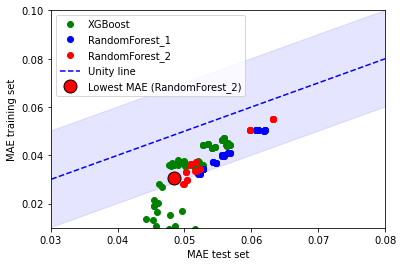

In [25]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(-Grid_ran2.cv_results_["mean_test_score"]),pd.Series(-Grid_ran2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(-Grid_ran222.cv_results_["mean_test_score"]),pd.Series(-Grid_ran222.cv_results_["mean_train_score"])],axis=1)
C = pd.concat([pd.Series(-Grid_xgb2.cv_results_["mean_test_score"]),pd.Series(-Grid_xgb2.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
C.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
C.sort_values("Test")
plt.plot(C.Test,C.Train,'og')
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot([0.0,0.1],[0.0,0.1],'--b')
plt.fill_between([0.0,0.1],[0.02,0.12],[-0.02,0.08],color='blue',alpha=0.1, label="_nolegend_")
plt.xlim([0.03,0.08])
plt.ylim([0.01,0.10])
plt.plot(B.Test[np.argmin(B.Test)],B.Train[np.argmin(B.Test)],'ro',markersize=13,mec="black")
plt.xlabel("MAE test set")
plt.ylabel("MAE training set")
plt.legend(["XGBoost","RandomForest_1","RandomForest_2","Unity line","Lowest MAE (RandomForest_2)"], loc="upper left")

.

Still on the edge of the shaded region (no drastic overfitting) but slighlty better than before.

However, for the same MAE, there is a XGBoost model with a lower level of overfitting (index: 30)

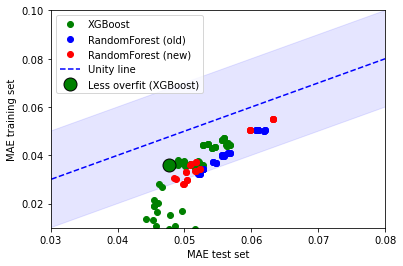

In [26]:
#Training vs. Validation accuracy
A = pd.concat([pd.Series(-Grid_ran2.cv_results_["mean_test_score"]),pd.Series(-Grid_ran2.cv_results_["mean_train_score"])],axis=1)
B = pd.concat([pd.Series(-Grid_ran222.cv_results_["mean_test_score"]),pd.Series(-Grid_ran222.cv_results_["mean_train_score"])],axis=1)
C = pd.concat([pd.Series(-Grid_xgb2.cv_results_["mean_test_score"]),pd.Series(-Grid_xgb2.cv_results_["mean_train_score"])],axis=1)
A.columns=["Test","Train"]
B.columns=["Test","Train"]
C.columns=["Test","Train"]
A.sort_values("Test")
B.sort_values("Test")
C.sort_values("Test")
plt.plot(C.Test,C.Train,'og')
plt.plot(A.Test,A.Train,'ob')
plt.plot(B.Test,B.Train,'or')
plt.plot([0.0,0.1],[0.0,0.1],'--b')
plt.fill_between([0.0,0.1],[0.02,0.12],[-0.02,0.08],color='blue',alpha=0.1, label="_nolegend_")
plt.xlim([0.03,0.08])
plt.ylim([0.01,0.10])
plt.plot(C.Test[30],C.Train[30],'go',markersize=13,mec="black")
plt.xlabel("MAE test set")
plt.ylabel("MAE training set")
plt.legend(["XGBoost","RandomForest (old)","RandomForest (new)","Unity line","Less overfit (XGBoost)"], loc="upper left")

In [27]:
#Hyperparameters
Grid_xgb2.cv_results_["params"][30]

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_split_loss': 0.02,
 'n_estimators': 200,
 'seed': 0,
 'subsample': 0.5}

.

Let's use this model to evaluate its performance on the Training and Test set.

----------------------
RMSE test (training): 2308.91 USD (1685.61 USD)
RMSLE test (training): 0.08 (0.05)
MAE test (training): 1788.43 USD (1176.59 USD)
MPE test (training): 14.94% (8.50 %)
R2 test (training): 0.83 (0.96)


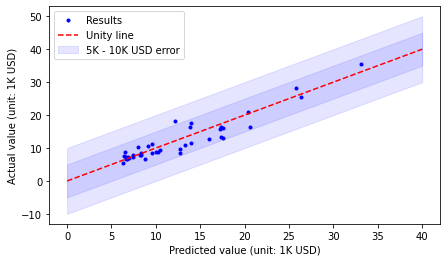

In [28]:
#Model training on the Training set and evaluation on the Test set
Best_xgb = xgb.XGBRegressor(**Grid_xgb2.cv_results_["params"][30])
Best_model_xgb = Best_xgb.fit(X_train_t,y_train_t)        
Predictions_xgb = Best_model_xgb.predict(X_test_t)        
Predictions_xgb_tr = Best_model_xgb.predict(X_train_t)


#Definitions
RMSE_xgb = np.sqrt(sum((10**Predictions_xgb - 10**y_test_t)**2)/len(y_test_t))
RMSE_xgb_tr = np.sqrt(sum((10**Predictions_xgb_tr - 10**y_train_t)**2)/len(y_train_t))
RMSLE_xgb = np.sqrt(sum((np.log10(10**Predictions_xgb+1) - np.log10(10**y_test_t+1))**2)/len(y_test_t))
RMSLE_xgb_tr = np.sqrt(sum((np.log10(10**Predictions_xgb_tr+1) - np.log10(10**y_train_t+1))**2)/len(y_train_t))
MAE_xgb = sum(abs(10**Predictions_xgb - 10**y_test_t))/len(y_test_t)
MAE_xgb_tr = sum(abs(10**Predictions_xgb_tr - 10**y_train_t))/len(y_train_t)
MPE_xgb = 100*sum(abs(10**Predictions_xgb - 10**y_test_t)/(10**y_test_t))/len(y_test_t)
MPE_xgb_tr = 100*sum(abs(10**Predictions_xgb_tr - 10**y_train_t)/(10**y_train_t))/len(y_train_t)
print("----------------------")
print("RMSE test (training): {:.2f} USD ({:.2f} USD)".format(RMSE_xgb, RMSE_xgb_tr))
print("RMSLE test (training): {:.2f} ({:.2f})".format(RMSLE_xgb, RMSLE_xgb_tr))
print("MAE test (training): {:.2f} USD ({:.2f} USD)".format(MAE_xgb, MAE_xgb_tr))
print("MPE test (training): {:.2f}% ({:.2f} %)".format(MPE_xgb,MPE_xgb_tr))
print("R2 test (training): {:.2f} ({:.2f})".format(r2_score(y_test_t,Predictions_xgb), r2_score(y_train_t,Predictions_xgb_tr)))


#Plot (Test dataset)
plt.figure(figsize=(7,4))
plt.plot(10**Predictions_xgb/1000, 10**y_test_t/1000,'.b');
plt.xlabel("Predicted value (unit: 1K USD)")
plt.ylabel("Actual value (unit: 1K USD)")
plt.plot([0,40],[0,40],'--r')
plt.fill_between([0,40], [5,45], [-5,35], color="blue",alpha=0.1)
plt.fill_between([0,40], [10,50], [-10,30], color="blue",alpha=0.1)
plt.legend(["Results", "Unity line", "5K - 10K USD error"], loc="upper left")

.

.

## **7. Model finalization**

Let's finalize the model use the whole dataset.

----------------------
RMSE: 1554.15 USD
RMSLE: 0.04
MAE: 1102.14 USD
MPE: 8.27%
R2: 0.96


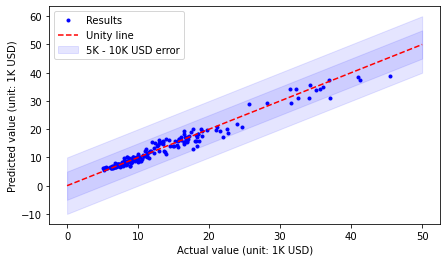

In [29]:
Best_xgb = xgb.XGBRegressor(**Grid_xgb2.cv_results_["params"][30])
Best_model_xgb_final = Best_xgb.fit(X_train,y_train)        
Predictions_xgb = Best_model_xgb_final.predict(X_train)        


#Defintions
RMSE_xgb = np.sqrt(sum((10**Predictions_xgb - 10**y_train)**2)/len(y_train))
RMSLE_xgb = np.sqrt(sum((np.log10(10**Predictions_xgb+1) - np.log10(10**y_train+1))**2)/len(y_train))
MAE_xgb = sum(abs(10**Predictions_xgb - 10**y_train))/len(y_train)
MPE_xgb = 100*sum(abs(10**Predictions_xgb - 10**y_train)/(10**y_train))/len(y_train)
print("----------------------")
print("RMSE: {:.2f} USD".format(RMSE_xgb))
print("RMSLE: {:.2f}".format(RMSLE_xgb))
print("MAE: {:.2f} USD".format(MAE_xgb))
print("MPE: {:.2f}%".format(MPE_xgb))
print("R2: {:.2f}".format(r2_score(y_train,Predictions_xgb)))


#Plot
plt.figure(figsize=(7,4))
plt.plot(10**y_train/1000,10**Predictions_xgb/1000,'.b');
plt.ylabel("Predicted value (unit: 1K USD)")
plt.xlabel("Actual value (unit: 1K USD)")
plt.plot([0,50],[0,50],'--r')
plt.fill_between([0,50], [5,55], [-5,45], color="blue",alpha=0.1)
plt.fill_between([0,50], [10,60], [-10,40], color="blue",alpha=0.1)
plt.legend(["Results", "Unity line", "5K - 10K USD error"], loc="upper left")

Text(0.5, 0, 'Residuals')

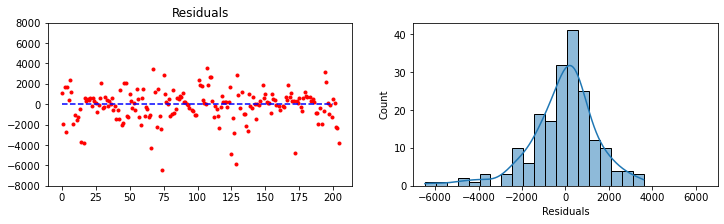

In [30]:
#Plot of the residuals
plt.figure(figsize=(12,3))  
plt.subplot(1,2,1); plt.plot(10**Predictions_xgb-10**y_train,'.r'); plt.title("Residuals"); plt.plot([0,200],[0,0], '--b'), plt.ylim([-8000,8000])
plt.subplot(1,2,2); sn.histplot(x = 10**Predictions_xgb-10**y_train, bins=20, kde=True); plt.xlim([-7000,7000]);plt.xlabel("Residuals")

.

.

## **8. Test on unseen data**

Now, it is possible to test the final model on the *unseen data* randomly chosen at the beginning of this notebook.

First, data must be transformed before the application of the model.

In [31]:
#Data transformation
X_test, y_test = Data_transformation(X_test,y_test)

RMSE: 1601.46 USD
RMSLE: 0.04
MAE: 1192.20 USD
MPE: 8.05 %


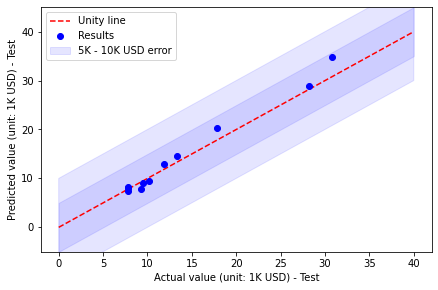

In [34]:
#Model application
Predictions_test = Best_model_xgb_final.predict(X_test)
RMSE_linear_test = np.sqrt(sum((10**Predictions_test - 10**y_test)**2)/len(y_test))
RMSLE_linear_test = np.sqrt(sum((np.log10(10**Predictions_test+1) - np.log10(10**y_test+1))**2)/len(y_test))
MAE_linear_test = sum(abs(10**Predictions_test - 10**y_test))/len(y_test)
MPE_linear_test = 100*sum(abs(10**Predictions_test - 10**y_test)/(10**y_test))/len(y_test)
print("RMSE: {:.2f} USD".format(RMSE_linear_test))
print("RMSLE: {:.2f}".format(RMSLE_linear_test))
print("MAE: {:.2f} USD".format(MAE_linear_test))
print("MPE: {:.2f} %".format(MPE_linear_test))

#Plot
plt.figure(figsize=(7,4.5))
plt.plot([0,40],[0,40],'--r')
plt.plot(10**y_test/1000, 10**Predictions_test/1000,'.b', markersize=12)
plt.ylabel("Predicted value (unit: 1K USD) - Test")
plt.xlabel("Actual value (unit: 1K USD) - Test")
plt.ylim([-5,45])
plt.fill_between([0,40], [5,45], [-5,35], color="blue",alpha=0.1)
plt.fill_between([0,40], [10,50], [-10,30], color="blue",alpha=0.1)
plt.legend(["Unity line","Results","5K - 10K USD error"],loc="upper left")

.

Let's use all the data to finalize the model further (Training + unseen data)

----------------------
RMSE: 1594.50 USD
RMSLE: 0.05
MAE: 1149.66 USD
MPE: 8.43%
R2: 0.96


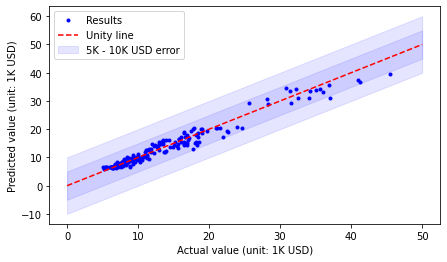

In [33]:
#Data transformation
X, y = Data_transformation(Data.drop(["price"],axis=1),Data.price)

#Finalized model
Best_ran = xgb.XGBRegressor(**Grid_xgb2.cv_results_["params"][30])
Best_model_xgb_final = Best_xgb.fit(X,y)        
Predictions_xgb = Best_model_xgb_final.predict(X)        

#Defintions
RMSE_xgb = np.sqrt(sum((10**Predictions_xgb - 10**y)**2)/len(y))
RMSLE_xgb = np.sqrt(sum((np.log10(10**Predictions_xgb+1) - np.log10(10**y+1))**2)/len(y))
MAE_xgb = sum(abs(10**Predictions_xgb - 10**y))/len(y)
MPE_xgb = 100*sum(abs(10**Predictions_xgb - 10**y)/(10**y))/len(y)
print("----------------------")
print("RMSE: {:.2f} USD".format(RMSE_xgb))
print("RMSLE: {:.2f}".format(RMSLE_xgb))
print("MAE: {:.2f} USD".format(MAE_xgb))
print("MPE: {:.2f}%".format(MPE_xgb))
print("R2: {:.2f}".format(r2_score(y,Predictions_xgb)))


#Plot
plt.figure(figsize=(7,4))
plt.plot(10**y/1000,10**Predictions_xgb/1000,'.b');
plt.ylabel("Predicted value (unit: 1K USD)")
plt.xlabel("Actual value (unit: 1K USD)")
plt.plot([0,50],[0,50],'--r')
plt.fill_between([0,50], [5,55], [-5,45], color="blue",alpha=0.1)
plt.fill_between([0,50], [10,60], [-10,40], color="blue",alpha=0.1)
plt.legend(["Results", "Unity line", "5K - 10K USD error"], loc="upper left")

.

### **Final thoughts**

The final MAEs (i.e., training, test, unseen, total) are not strongly different meaning that the model does not overfit the data drastically.

Clearly, a larger dataset may lead to more precise model even though the final results obtained in this notebook are still fairly good.